In [1]:
#Installing the modules
!pip install keras
!pip install tensorflow
!pip install scikeras

In [167]:
#Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, Adadelta, Adagrad, Nadam, SGD
from scikeras.wrappers import KerasRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Read the dataset
data = pd.read_csv('gas_turbines.csv')
data.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [5]:
#Check for blanks
data.isna().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

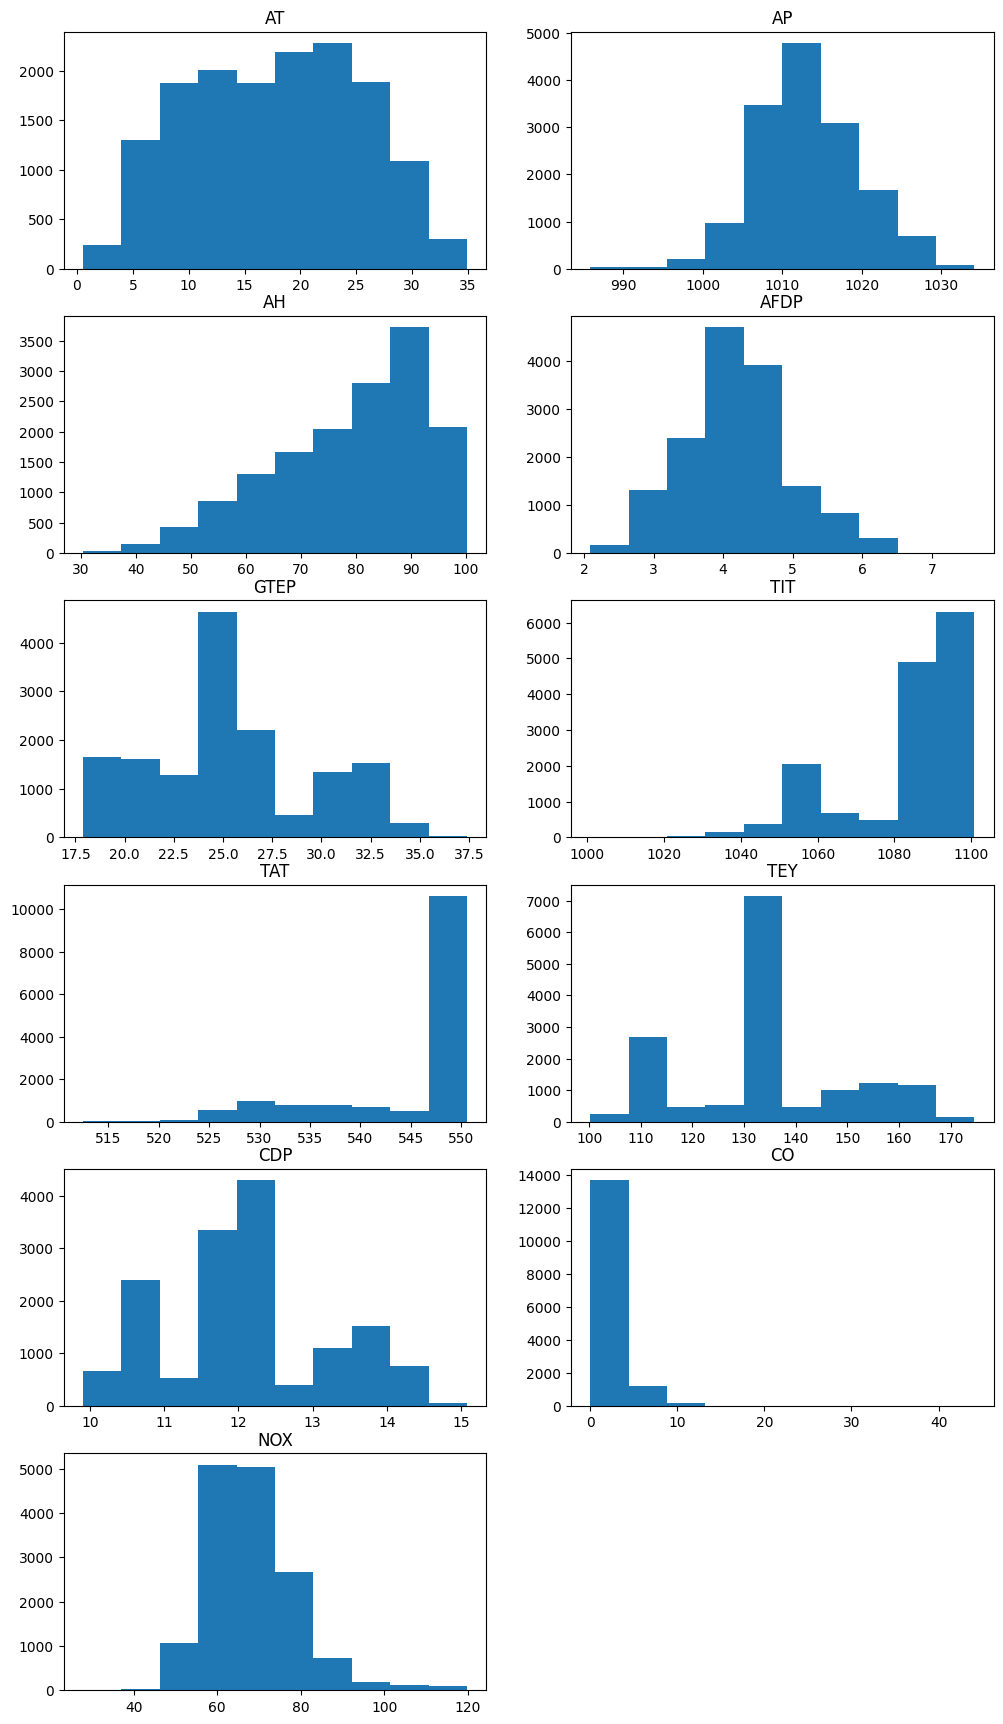

In [6]:
#plottin histograms for all the attributes
plt.figure(figsize = (12,40))
d = len(data.columns)
c = 1
for i in data.columns:
  plt.subplot(d,2,c)
  plt.title(i)
  plt.hist(data[i])
  c +=1


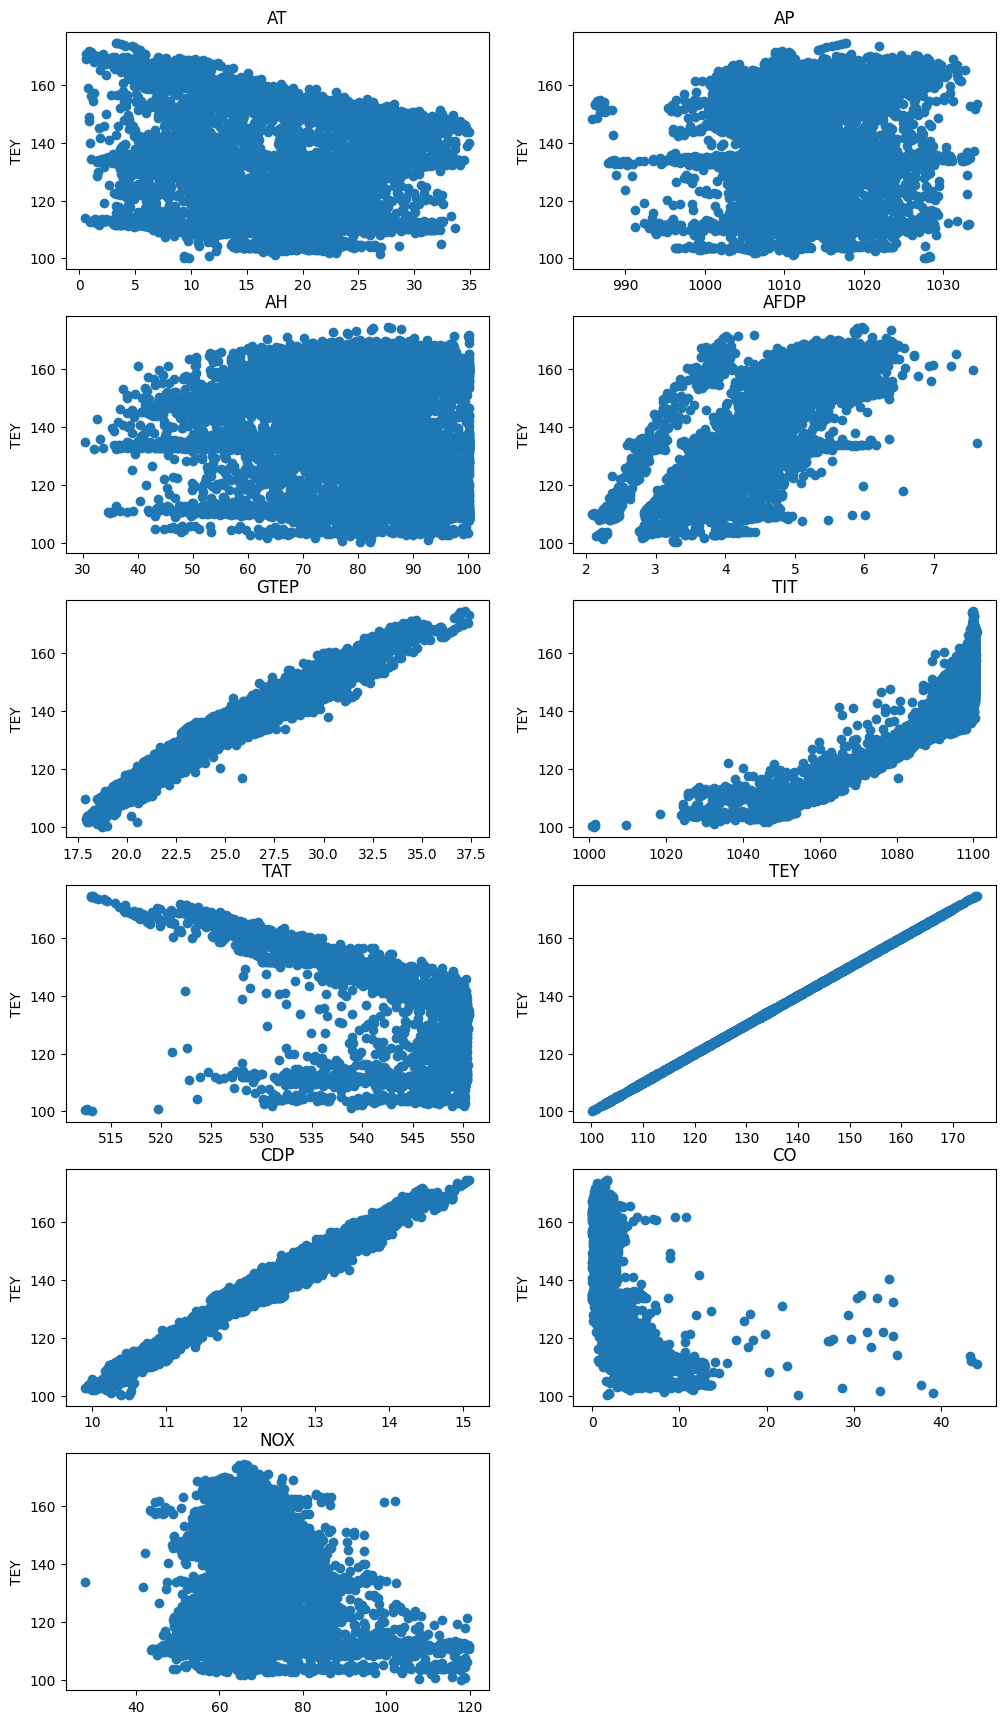

In [7]:
#plotting scatter between the dependent variable and the independent variables
plt.figure(figsize = (12,40))
d = len(data.columns)
c = 1
for i in data.columns:
  plt.subplot(d,2,c)
  plt.title(i)
  plt.scatter(data[i], data['TEY'])
  plt.ylabel('TEY')
  c +=1

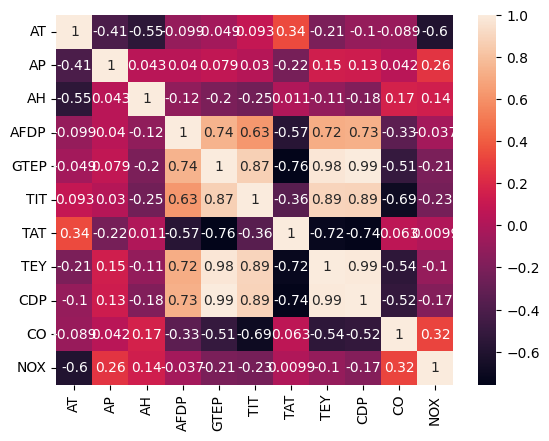

In [8]:
#plotting a heatmap with correlation value
sns.heatmap(data.corr(), annot = True)
plt.show()

In [156]:
#split the data into dependent and independent variable
x = data.drop(['TEY'], axis =1)
y = data[['TEY']]

In [157]:
#Standardizing the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

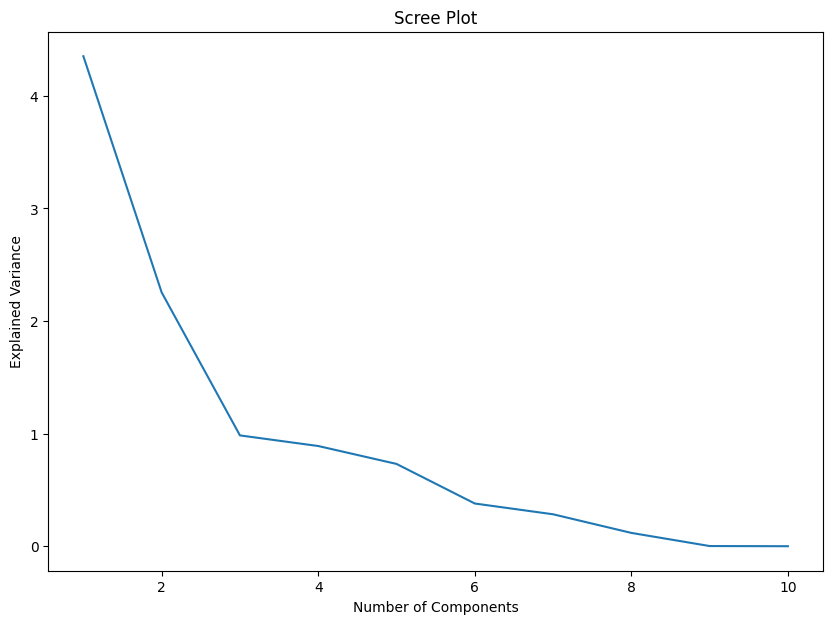

In [158]:
pca = PCA()
pca.fit(x_scaled)

plt.figure(figsize = (10,7))
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [160]:
#Implementing PCA to find 3 best features and storing them into a dataframe
pc = PCA(n_components = 3)
x_pc = pd.DataFrame(pc.fit_transform(x_scaled), columns = ['PC1', 'PC2', 'PC3'])

In [161]:
x_pc

,PC1,PC2,PC3
0,2.963129,1.552786,-1.061514
1,2.966501,1.605388,-1.035055
2,2.939215,1.575035,-0.952600
3,2.928877,1.570380,-0.883506
4,2.917244,1.560598,-0.836430
...,...,...,...
15034,3.353446,1.456841,-1.004037
15035,3.340092,1.757787,-0.922362
15036,3.826411,2.875839,-0.043317
15037,3.649831,2.682406,-0.287733


In [162]:
#splitting the data into training and testing part and using only small percentage of the dataset to find the best parameters for the model
xtrain, xtest, ytrain, ytest = train_test_split(x_pc, y_scaled, train_size=0.1, random_state = 91)

In [163]:
xtrain.shape

(1503, 3)

In [164]:
input_dim = xtrain.shape[1]
input_dim

3

###Hyperparameter tuning for Batch Size and Epochs

In [165]:
#Create a user function for the model
def create_model():
  model = Sequential()
  model.add(Dense(8, input_dim=input_dim, kernel_initializer='uniform', activation = 'relu'))
  model.add(Dense(4, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'accuracy')
  return model

In [166]:
#Building a model and running GridSearchCV to find the batch_size and epochs
model = KerasRegressor(model = create_model, verbose = 0)
batch_size = [10,20,30,40,50]
epochs = [10,50,100,200]
param_grid = dict(batch_size = batch_size, epochs = epochs)
grid = GridSearchCV(model, param_grid, cv = KFold(), verbose = 5)
grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ..........batch_size=10, epochs=10;, score=0.281 total time=   3.8s
[CV 2/5] END ..........batch_size=10, epochs=10;, score=0.444 total time=   3.7s
[CV 3/5] END ..........batch_size=10, epochs=10;, score=0.329 total time=   3.9s
[CV 4/5] END ..........batch_size=10, epochs=10;, score=0.442 total time=   4.9s
[CV 5/5] END ..........batch_size=10, epochs=10;, score=0.352 total time=   3.1s
[CV 1/5] END ..........batch_size=10, epochs=50;, score=0.370 total time=  13.4s
[CV 2/5] END ..........batch_size=10, epochs=50;, score=0.445 total time=  21.6s
[CV 3/5] END ..........batch_size=10, epochs=50;, score=0.428 total time=  13.9s
[CV 4/5] END .........batch_size=10, epochs=50;, score=-0.007 total time=  21.6s
[CV 5/5] END ..........batch_size=10, epochs=50;, score=0.475 total time=  13.2s
[CV 1/5] END .........batch_size=10, epochs=100;, score=0.382 total time=  25.9s
[CV 2/5] END .........batch_size=10, epochs=100

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KerasRegressor(model=<function create_model at 0x7c8cfc30d360>, verbose=0),
             param_grid={'batch_size': [10, 20, 30, 40, 50],
                         'epochs': [10, 50, 100, 200]},
             verbose=5)

In [168]:
#printing the best score and parameters
print(grid.best_score_, grid.best_params_)

0.43733085288133344 {'batch_size': 10, 'epochs': 200}


In [195]:
batch_epoch = list(dict.values(grid.best_params_))
batch_epoch

[10, 200]

###Hyperparameter Tuning to find the best Optimizer

In [203]:
#Creating a user function for the model
def create_model(optimizer = 'adam'):
  model = Sequential()
  model.add(Dense(8, input_dim=input_dim, kernel_initializer='uniform', activation = 'relu'))
  model.add(Dense(4, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = 'accuracy')
  return model

In [204]:
#Building a model and using GridSearchCV to find the best optimizer
model = KerasRegressor(model = create_model, batch_size = batch_epoch[0], epochs = batch_epoch[1], verbose = 0)
optimizer = ['SGD', 'RMSprop', 'Adagrad',
             'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer = optimizer)
grid = GridSearchCV(model, param_grid, cv = KFold(), verbose = 5)
grid_op = grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .....................optimizer=SGD;, score=0.382 total time= 1.4min
[CV 2/5] END .....................optimizer=SGD;, score=0.446 total time= 1.4min
[CV 3/5] END .....................optimizer=SGD;, score=0.439 total time= 1.4min
[CV 4/5] END .....................optimizer=SGD;, score=0.445 total time= 1.0min
[CV 5/5] END .....................optimizer=SGD;, score=0.475 total time=  49.1s
[CV 1/5] END .................optimizer=RMSprop;, score=0.380 total time=  47.1s
[CV 2/5] END .................optimizer=RMSprop;, score=0.446 total time= 1.4min
[CV 3/5] END .................optimizer=RMSprop;, score=0.439 total time= 1.2min
[CV 4/5] END .................optimizer=RMSprop;, score=0.445 total time= 1.2min
[CV 5/5] END .................optimizer=RMSprop;, score=0.475 total time= 1.5min
[CV 1/5] END .................optimizer=Adagrad;, score=0.382 total time=  50.5s
[CV 2/5] END .................optimizer=Adagrad;,

In [205]:
#printing the best score and parameter for the model
print(grid.best_score_, grid.best_params_)

0.4373749573914812 {'optimizer': 'Adam'}


In [207]:
op = list(dict.values(grid.best_params_))
op[0]

'Adam'

###Hyperparameter Tuning for Learning Rate

In [210]:
# Define a list of activation functions to tune
learning_rate = [0.1, 0.01, 0.001]
best_score = 0
best_learning_rate = None
for learning in learning_rate:
    # Define a function that creates your Keras model with a specific activation function
    def create_model():
      model = Sequential()
      model.add(Dense(8, input_dim = input_dim, kernel_initializer = 'uniform', activation = 'relu'))
      model.add(Dense(4, kernel_initializer = 'uniform', activation = 'tanh'))
      model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
      optimizer = Adam(learning_rate=learning)
      model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = 'accuracy')
      return model

    # Create a KerasRegressor with the custom model creation function
    model = KerasRegressor(build_fn=create_model,batch_size =10, epochs = 200, verbose=0)

    # Train the model and evaluate its performance
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    score = model.score(xtrain, ytrain)
    print(f' Model Score with learning rate {learning} is : {score}')
    # Check if this activation function performed better
    if score > best_score:
        best_score = score
        best_learning_rate = learning

print(f"Best Learning Rate: {best_learning_rate}, Score: {best_score:.4f}")

 Model Score with learning rate 0.1 is : 0.4315590190207159
 Model Score with learning rate 0.01 is : 0.4387794728147394
 Model Score with learning rate 0.001 is : 0.4381420463758542
Best Learning Rate: 0.01, Score: 0.4388


###Hyperparameter Tuning for Activation Functions

In [212]:
# Define a list of activation functions to tune
activation_functions = ['softmax', 'softplus', 'softsign',
                        'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
best_score = 0
best_activation_function = None
for activation_function in activation_functions:
    # Define a function that creates your Keras model with a specific activation function
    def create_model():
      model = Sequential()
      model.add(Dense(8, input_dim = input_dim, kernel_initializer = 'uniform', activation = activation_function))
      model.add(Dense(4, kernel_initializer = 'uniform', activation = activation_function))
      model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
      optimizer = Adam(learning_rate=0.01)
      model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = 'accuracy')
      return model

    # Create a KerasRegressor with the custom model creation function
    model = KerasRegressor(build_fn=create_model,batch_size =10, epochs = 200, verbose=0)

    # Train the model and evaluate its performance
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    score = model.score(xtrain, ytrain)
    print(f' Model Score with activation functions {activation_function} is : {score}')

    # Check if this activation function performed better
    if score > best_score:
        best_score = score
        best_activation_function = activation_function

print(f"Best activation function: {best_activation_function}, Score: {best_score:.4f}")


 Model Score with activation functions softmax is : 0.43830734749620437
 Model Score with activation functions softplus is : 0.43864255984642353
 Model Score with activation functions softsign is : 0.43851302793474656
 Model Score with activation functions relu is : 0.43863139387939976
 Model Score with activation functions tanh is : 0.4387574156934271
 Model Score with activation functions sigmoid is : 0.4387213446296109
 Model Score with activation functions hard_sigmoid is : 0.4379207299035828
 Model Score with activation functions linear is : 0.4377496785065639
Best activation function: tanh, Score: 0.4388


###Hyperparameter Tuning for Kernel Initializers

In [213]:
# Define a list of activation functions to tune
kernel_initializers = ['zero', 'uniform', 'normal']
best_score = 0
best_kernel_initializer = None
for kernel in kernel_initializers:
    # Define a function that creates your Keras model with a specific activation function
    def create_model():
      model = Sequential()
      model.add(Dense(8, input_dim = input_dim, kernel_initializer = kernel, activation = 'tanh'))
      model.add(Dense(4, kernel_initializer = kernel, activation = 'tanh'))
      model.add(Dense(1, kernel_initializer = kernel, activation = 'sigmoid'))
      optimizer = Adam(learning_rate=0.01)
      model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = 'accuracy')
      return model

    # Create a KerasRegressor with the custom model creation function
    model = KerasRegressor(build_fn=create_model,batch_size =10, epochs = 200, verbose=0)

    # Train the model and evaluate its performance
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    score = model.score(xtrain, ytrain)
    print(f' Model Score with Kernel Initializer {kernel} is : {score}')
    # Check if this activation function performed better
    if score > best_score:
        best_score = score
        best_kernel_initializer = kernel

print(f"Best Kernel Initializers : {best_kernel_initializer}, Score: {best_score:.4f}")

 Model Score with Kernel Initializer zero is : -5.079422477072271e-06
 Model Score with Kernel Initializer uniform is : 0.4388104960124004
 Model Score with Kernel Initializer normal is : 0.4387258449327194
Best Kernel Initializers : uniform, Score: 0.4388


###Hyperparameter Tuning for Number of Nuerons in layer 1 and 2

In [214]:
# Define a list of activation functions to tune
nueron1 = [8,12,18,24]
nueron2 = [4,8,12]
best_score = 0
best_nuerons = None
for n in nueron1:
  for x in nueron2:
    # Define a function that creates your Keras model with a specific activation function
    def create_model():
      model = Sequential()
      model.add(Dense(n, input_dim = input_dim, kernel_initializer = 'uniform', activation = 'tanh'))
      model.add(Dense(x, kernel_initializer = 'uniform', activation = 'tanh'))
      model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))
      optimizer = Adam(learning_rate=0.01)
      model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = 'accuracy')
      return model

    # Create a KerasRegressor with the custom model creation function
    model = KerasRegressor(build_fn=create_model,batch_size =10, epochs = 200, verbose=0)

    # Train the model and evaluate its performance
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    score = model.score(xtrain, ytrain)
    print(f' Model Score with number of nuerons in 1st layer {n} and 2nd layer {x} is : {score}')
    # Check if this activation function performed better
    if score > best_score:
        best_score = score
        best_nueron = (n,x)

print(f"Best Number of Nuerons: {best_nueron}, Score: {best_score:.4f}")


 Model Score with number of nuerons in 1st layer 8 and 2nd layer 4 is : 0.43849750905506213
 Model Score with number of nuerons in 1st layer 8 and 2nd layer 8 is : 0.43883799307364835
 Model Score with number of nuerons in 1st layer 8 and 2nd layer 12 is : 0.43886312867039345
 Model Score with number of nuerons in 1st layer 12 and 2nd layer 4 is : 0.43876227671819434
 Model Score with number of nuerons in 1st layer 12 and 2nd layer 8 is : 0.4388083928570825
 Model Score with number of nuerons in 1st layer 12 and 2nd layer 12 is : 0.438813012441415
 Model Score with number of nuerons in 1st layer 18 and 2nd layer 4 is : 0.4384890030073938
 Model Score with number of nuerons in 1st layer 18 and 2nd layer 8 is : 0.43836425037950033
 Model Score with number of nuerons in 1st layer 18 and 2nd layer 12 is : 0.4384849115389897
 Model Score with number of nuerons in 1st layer 24 and 2nd layer 4 is : 0.4383269083646031
 Model Score with number of nuerons in 1st layer 24 and 2nd layer 8 is : 0.4

In [215]:
#Creating a user function with optimum parameters calculated above
def create_model():
  model = Sequential()
  model.add(Dense(8, input_dim = input_dim, kernel_initializer = 'uniform', activation = 'tanh'))
  model.add(Dense(12, kernel_initializer = 'uniform', activation = 'tanh'))
  model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))
  optimizer = Adam(learning_rate=0.01)
  model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = 'accuracy')
  return model

In [216]:
# Create a KerasClassifier
model_final = KerasRegressor(build_fn=create_model,batch_size =10, epochs = 200, verbose=0)

In [217]:
#Again Splitting the data with 30% test sample
xtrain_f, xtest_f, ytrain_f, ytest_f = train_test_split(x_pc, y_scaled, test_size=0.3, random_state = 91)

In [219]:
# Train the model and predict the values of testing data
model_final.fit(xtrain_f, ytrain_f)

KerasRegressor(
	model=None
	build_fn=<function create_model at 0x7c8cf83cf520>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
)

In [220]:
y_pred = model_final.predict(xtest_f)

In [221]:
print("Mean Squared Error :", mean_squared_error(ytest_f, y_pred))
print("R^2 Score :", r2_score(ytest_f, y_pred))

Mean Squared Error : 0.5496383340601974
R^2 Score : 0.4416334435564653
